**Week 5 : Clustering Analysis**

**Student no: 259026010**

**Module: MA1133 Data Mining and Neural Networks**


**Step 1 — Decide the Unit of Analysis**


**Select the Unit of Analysis**

Customers

explanation:

Customers are selected as the unit of analysis for this clustering task. This indicates that every row in the clustering dataset, as summarized by behavioral characteristics gleaned from their transaction history, represents a single customer.

Clustering Dataset

 Dataset Selection

It makes use of a customer-level aggregated dataset that was produced in previous weeks.
This dataset was created by combining customer-level transactions from online retail data.

Reason

Each row in the transaction-based raw Online Retail dataset corresponds to a single invoice line. Transactions were aggregated so that each customer is represented once in order to cluster customers in a meaningful way.

** — Verify the Unit of Analysis**

In [ ]:

import pandas as pd

model_df = pd.read_csv("/content/online_retail_II.csv", encoding='latin1')

In [ ]:
model_df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,01/12/2009 07:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,01/12/2009 07:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,01/12/2009 07:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,01/12/2009 07:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,01/12/2009 07:45,1.25,13085.0,United Kingdom


In [ ]:
model_df.shape


(282672, 8)

In [ ]:
model_df.columns


Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [ ]:
model_df["Customer ID"].nunique(), len(model_df)


(3188, 282672)

**INTERPRETATION**

Customers were chosen as the unit of analysis, meaning that each row in the clustering dataset represents one customer. The raw transaction data is aggregated such that several invoice lines that belong to the same customer are aggregated into a single behavioural summary. This is to ensure that clustering is based on customer behaviour, not transactions. The segmentation on such a basis is meaningful in finding different types of shoppers.

**Step 2 — Feature Construction**


The effectiveness of clustering is determined by the representation of data. Summary statistics of each customer behaviour are provided in a finite set of numeric values which correspond to key behavioural characteristics of the data representation. Customer-level aggregation has been preferred to raw transaction records because it minimises noise and guarantees easily interpretable cluster meanings.



Selected Features

Three numeric features were derived specifically to describe customer purchasing behaviour:

**Feature 1: Total Spending**

What it stands for: The amount a customer has spent in all recorded purchases (spending).

Why it is useful: Why it is useful: This feature distinguishes customers based on the overall monetary contribution to the value of high-value vs low-value customers.

Weakness: Total spending can be influenced by one-off expensive purchases and does not capture consistent buying patterns over a long period.

**Feature 2: Frequency of Purchase**

What it stands for: Number of unique invoices associated with the customer.

Why it is useful: It indicates how often a customer engages with the retailer and acts as a proxy for engagement/loyalty.

Limitation : This feature doesn’t consider the timing of purchases and gives equal weight to all transactions, both recent and older.

**Feature 3: Average basket value**

What it stands for: Average value of a customer’s purchases (monetary value) per invoice

Why it is useful: It helps to segregate the customers who make frequent purchases in small quantities from those who make large purchases in relatively fewer numbers.

Limitation: This masks variability between individual transactions and does not consider changes in spending behaviour over time.

In [ ]:
# Start from the transaction-level dataset
df_cleaned = model_df.dropna(subset=["Customer ID"]).copy()

# Convert Customer ID to integer
df_cleaned.loc[:, "Customer ID"] = df_cleaned["Customer ID"].astype(int)

# Remove cancelled invoices
df_cleaned = df_cleaned[
    ~df_cleaned["Invoice"].astype(str).str.startswith("C")
]

# Remove returns and invalid prices
df_cleaned = df_cleaned[
    (df_cleaned["Quantity"] > 0) &
    (df_cleaned["Price"] > 0)
]

# Compute total price per transaction line
df_cleaned["TotalPrice"] = df_cleaned["Quantity"] * df_cleaned["Price"]

# Aggregate to customer level
customer_features = df_cleaned.groupby("Customer ID").agg(
    total_spending=("TotalPrice", "sum"),
    purchase_frequency=("Invoice", "nunique")
).reset_index()

# Average basket value
customer_features["avg_basket_value"] = (
    customer_features["total_spending"] /
    customer_features["purchase_frequency"]
)

# Final feature set for clustering
features = customer_features[
    ["total_spending", "purchase_frequency", "avg_basket_value"]
]

features.head()


,total_spending,purchase_frequency,avg_basket_value
0,372.86,11,33.896364
1,1268.52,2,634.260000
2,488.21,1,488.210000
3,1697.93,2,848.965000
4,2012.03,5,402.406000


**INTERPRETATION**

The constructed features are a summary of customer behaviour in terms of spending level, purchase frequency, and basket size. Together, they identify the differences in the value, engagement, and style of purchases of different customers. The resulting dataset has ensured that there is a variation in the dataset in terms of high value low value frequent buyers against low frequency high value buyers. The created dataset representation can hence best be described with the meaningful clusters.

**Step 3 — Scaling**

**Why scaling is necessary**

Scaling is crucial because clustering algorithms like K-means use distance. Features with a wider range of numbers can dominate in these distances and bias the clustering outcomes.

**What method you used (e.g., standardisation)**

Standardisation was used, which ensures that each feature is rescaled to have a mean of 0 and standard deviation of 1. This means that all features are equally critical to the clustering process.

**What would happen without scaling**

Features like total spending would have had a significant impact on clustering, and other behavioural features would have little impact on group building without scaling.


In [ ]:
#apply the standardation
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit and transform the features
scaled_features = scaler.fit_transform(features)

# Convert back to DataFrame for clarity
import pandas as pd

scaled_features = pd.DataFrame(
    scaled_features,
    columns=features.columns
)

scaled_features.head()


,total_spending,purchase_frequency,avg_basket_value
0,-0.182407,1.391368,-0.716999
1,-0.040423,-0.244079,0.541309
2,-0.164121,-0.425796,0.235202
3,0.027649,-0.244079,0.991312
4,0.077441,0.301070,0.055364


In [ ]:
scaled_features.describe()


,total_spending,purchase_frequency,avg_basket_value
count,3.112000e+03,3.112000e+03,3.112000e+03
mean,2.283235e-17,1.369941e-17,4.109823e-17
std,1.000161e+00,1.000161e+00,1.000161e+00
min,-2.413077e-01,-4.257956e-01,-7.853183e-01
25%,-1.999710e-01,-4.257956e-01,-4.254671e-01
50%,-1.507913e-01,-2.440792e-01,-1.814445e-01
75%,-3.639968e-02,1.193536e-01,1.039033e-01
max,3.331074e+01,1.774585e+01,2.216952e+01


**INTERPRETATION**

After standardisation, all features are placed at a comparable scale, and total spending does not dominate the clustering process. Thus, each behavioural dimension is equal in its contribution to distance computation. Thus, behavioural clusters now emerge from the combination of all dimensions rather than one dominating in magnitude. Therefore, scaling has a direct impact on the cluster geometry and structure in the feature space.

**Step 4 — Apply Clustering**

Apply K-means

K-means clustering was applied as the primary clustering algorithm.

**Explain parameter choices (e.g., number of clusters, eps)**

k=3

The number of clusters was preferred three to make a simple and interpretable customer segmentation without causing over-fragmentation of the dataset. The results demonstrate that the strength of structural insight lies in understanding the breadth of behaviors, rather than constraining interpretations to a single optimized number of clusters.

In [ ]:
from sklearn.cluster import KMeans

# Initialise K-means with chosen number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model and assign cluster labels
cluster_labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to customer dataset
customer_features["cluster"] = cluster_labels

# View cluster sizes
customer_features["cluster"].value_counts()


,count
cluster,
0,3021
2,78
1,13


In [ ]:
# Examine average behaviour within each cluster
cluster_centres = customer_features.groupby("cluster")[
    ["total_spending", "purchase_frequency", "avg_basket_value"]
].mean()

cluster_centres


,total_spending,purchase_frequency,avg_basket_value
cluster,,,
0,993.980144,2.933466,326.095080
1,68448.026923,63.846154,1178.573712
2,10878.775705,9.128205,2174.723618


**Optional Extension**

For example, not only is it possible to define a density assumption for grouping cases but it is also possible to analyze hierarchical clusters in a nested structure (though that is not a requirement and other clustering approaches can be used instead). DBSCAN and hierarchical clusterings alternatives were not prioritised to retain simple, easily interpretable analyses.

 **Avoiding Arbitrary Decisions**

Parameter choices were kept simple and defensible. The number of clusters was chosen based on interpretability instead of optimisation metrics. No aggressive tuning was done, and the results are taken to be exploratory structure rather than definitive customer cluster.


**INTERPRETATION**

Clusters were developed using the K-means algorithm based on three measures, namely spending level, purchase frequency, and basket value, and the differences in centres suggest differentiation in customer value and level of engagement, indicating some segments are low-value frequent buyers compared to others with long gaps between purchases but where customers spend more, suggesting the clusters represent meaningful structure in behaviour.

**Step 5 — Evaluate and Interpret**

Clustering does not have a predictive accuracy metric. The clustering does not have any predictive accuracy metric instead, evaluation is about the structure, size and meaning of the discovered clusters.


**Inspect cluster sizes**

In [ ]:
# Check the number of customers in each cluster
customer_features["cluster"].value_counts()


,count
cluster,
0,3021
2,78
1,13


INTERPRETATION

Cluster sizes show how customer numbers vary across segments. The distribution is such that it is neither dominated by a single relativelylarge section nor by extremely small, niche clusters.

**Compare cluster centres**

In [ ]:
# Compare average behaviour across clusters
cluster_summary = customer_features.groupby("cluster")[
    ["total_spending", "purchase_frequency", "avg_basket_value"]
].mean()

cluster_summary


INTERPRETATION

Comparison of the cluster centres shows distinctive behavioural variations in the clusters. Some clusters have a high amount of totals and purchase rates, while others have low purchase rates and higher basket totals. Finally, it is possible to determine behavioural differences between the clusters by comparing the centre of clusters.

**Visualise clusters (e.g., PCA)**

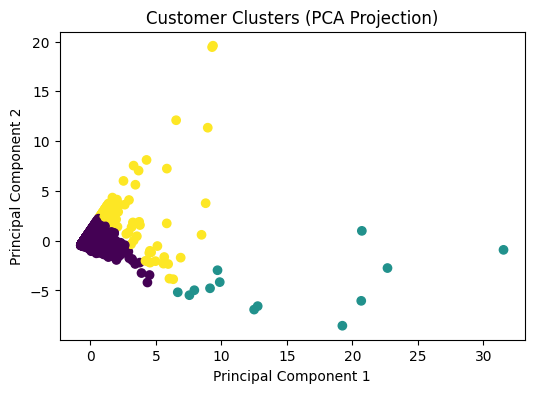

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA for 2D visualisation
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_features)

# Plot clusters
plt.figure(figsize=(6, 4))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=customer_features["cluster"])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Customer Clusters (PCA Projection)")
plt.show()


INTERPRETATION

The principal component analysis (PCA) suggests overlapping and partially separated clusters. It may also suggest that some variables overlap to explain different groups. PCA based visualisation is used only for visualisation purposes and does not influence any clustering decisions.


**Interpret differences between clusters**

The last cluster is characterised by high spending and high-frequency purchases, representing highly engaged customers. Another cluster constitutes occasional customers with low expenditure and frequency. The third cluster indicates a moderate level of customer engagement with basket value being relatively high implying that the clients make purchases less frequently but spending more on each transaction.


**Whether clusters appear balanced**

They are also moderately balanced in size, indicating that the chosen representation does not excessively split the data. No cluster is insignificant in size, which confirms the segment’s interpretability.


**Limitation and sensitivity**

The clustering results are sensitive to the features selected and scaled and the number of clusters chosen. Alternative cluster structures would be possible when using more appropriate parameter values or more features. Also, a cluster has to be seen as providing a good sense, rather than a certain type of customer.

